In [1]:
%set_env CUDA_VISIBLE_DEVICES=1

from timeit import default_timer
from src.models.ResNet import *
from src.utils.trainer import *
from src.utils.tools import *
from src.utils.splitNN import SplitNN, SplitOptimizer
from src.utils.dataloader import cifar_100_dataloader
from torch.multiprocessing import set_start_method
from torch.optim.lr_scheduler import MultiStepLR
from torch.optim import Adam, SGD
from torch import tensor
from torch import nn

import matplotlib.pyplot as plt
import pandas as pd
import syft as sy
import torch
import os
import gc

env: CUDA_VISIBLE_DEVICES=1
{'apple': 0, 'aquarium_fish': 1, 'baby': 2, 'bear': 3, 'beaver': 4, 'bed': 5, 'bee': 6, 'beetle': 7, 'bicycle': 8, 'bottle': 9, 'bowl': 10, 'boy': 11, 'bridge': 12, 'bus': 13, 'butterfly': 14, 'camel': 15, 'can': 16, 'castle': 17, 'caterpillar': 18, 'cattle': 19, 'chair': 20, 'chimpanzee': 21, 'clock': 22, 'cloud': 23, 'cockroach': 24, 'couch': 25, 'crab': 26, 'crocodile': 27, 'cup': 28, 'dinosaur': 29, 'dolphin': 30, 'elephant': 31, 'flatfish': 32, 'forest': 33, 'fox': 34, 'girl': 35, 'hamster': 36, 'house': 37, 'kangaroo': 38, 'keyboard': 39, 'lamp': 40, 'lawn_mower': 41, 'leopard': 42, 'lion': 43, 'lizard': 44, 'lobster': 45, 'man': 46, 'maple_tree': 47, 'motorcycle': 48, 'mountain': 49, 'mouse': 50, 'mushroom': 51, 'oak_tree': 52, 'orange': 53, 'orchid': 54, 'otter': 55, 'palm_tree': 56, 'pear': 57, 'pickup_truck': 58, 'pine_tree': 59, 'plain': 60, 'plate': 61, 'poppy': 62, 'porcupine': 63, 'possum': 64, 'rabbit': 65, 'raccoon': 66, 'ray': 67, 'road': 68

In [2]:
torch.manual_seed(0)

client_ids = [0, 1, 2]
data_paths = {
    0: {
        'train': 'data/clients/client1/cifar100/split_1/train',
        'val': 'data/clients/client1/cifar100/split_1/test'
    },
    1: {
        'train': 'data/clients/client2/cifar100/split_1/train',
        'val': 'data/clients/client2/cifar100/split_1/test'
    },
    2: {
        'train': 'data/clients/client3/cifar100/split_1/train',
        'val': 'data/clients/client3/cifar100/split_1/test'
    }
}

save_path = 'results/cifar100/non-iid'

# To get around the PyTorch issue described by me at:
# https://github.com/OpenMined/PySyft/issues/3848
# This, however, leads to inefficient use of GPU memory
# and problems related to multiprocessing

torch.set_default_tensor_type(torch.cuda.FloatTensor)
hook = sy.TorchHook(torch)

server_model = ResNetServer18(num_classes=100)
client_model = ResNetClient(num_channels=3)

criterion = nn.NLLLoss(reduction='mean')

# CIFAR-100 Optimal Hyperparameters are taken from:
# https://arxiv.org/abs/1708.04552v2

optim = SGD
optim_params = {
    'lr': 0.1, 
    'weight_decay': 5e-4,
    'momentum': 0.9
}

scheduler = MultiStepLR
scheduler_params = {
    'milestones': [60, 120, 160],
    'gamma': 0.2, 
}

dataloader_params = {
    #'shuffle' : True,
    'num_workers' : 8,
}

batch_size = 512
batch_sizes = {
    0: int(batch_size * .45),
    1: int(batch_size * .24),
    2: int(batch_size * .31)
}

# PyTorch multiprocessing errors out with DataLoader tensors created on GPU 
# (as with torch.set_default_tensor_type(torch.cuda.FloatTensor)) and num_workers > 0.
# Therefore, we check if this is the case, and if so, change the spawn method. 
# More details at https://pytorch.org/docs/master/notes/multiprocessing.html
if torch.tensor([0]).is_cuda and dataloader_params['num_workers'] > 0:
    set_start_method('spawn', force=True)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Workers are automatically put on to the appropriate devices and clients
server = init_worker('server', server_model, hook, device, requires_grad=True) 
#                       finetune='./results/cifar100_baseline/alternating_training/batch_norm/split_learning/new_running_stats/epoch_20/server_trained_on_client_2.pth')

clients = {}
clients[0] = init_worker('client_'+str(0), client_model, hook, device, requires_grad=True)
#                         finetune='./results/cifar100_baseline/alternating_training/batch_norm/split_learning/new_running_stats/epoch_20/client_trained_on_client_0.pth')
clients[1] = init_worker('client_'+str(1), client_model, hook, device, requires_grad=True)
#                         finetune='./results/cifar100_baseline/alternating_training/batch_norm/split_learning/new_running_stats/epoch_20/client_trained_on_client_1.pth')
clients[2] = init_worker('client_'+str(2), client_model, hook, device, requires_grad=True)
#                         finetune='./results/cifar100_baseline/alternating_training/batch_norm/split_learning/new_running_stats/epoch_20/client_trained_on_client_2.pth')

splitNN = SplitNN(clients, server)
criterion = criterion.to(device)

# Optimizers
server_optim = optim(splitNN.server.parameters(), **optim_params)
client_optims = {}
for c, client in splitNN.clients.items():
    client_optims[c] = optim(client.parameters(), **optim_params)

split_optim = SplitOptimizer(client_optims, server_optim)

# Schedulers
server_scheduler = scheduler(split_optim.server, **scheduler_params)
client_schedulers = {}
for c, client_optim in split_optim.clients.items():
    client_schedulers[c] = scheduler(client_optim, **scheduler_params)

split_scheduler = SplitScheduler(client_schedulers, server_scheduler)
    
# Get the data
dataloaders = {}
for c in client_ids: 
    dataloaders[c] = {}
    dataloaders[c]['train'] = cifar_100_dataloader(data_paths[c]['train'], batch_size=batch_sizes[c], **dataloader_params)
    dataloaders[c]['val'] = cifar_100_dataloader(data_paths[c]['val'], batch_size=batch_sizes[c], **dataloader_params)

trainer = SplitTrainer(client_ids=client_ids, splitNN=splitNN, split_optim=split_optim,
                       split_scheduler=split_scheduler, dataloaders=dataloaders, criterion=criterion, 
                       num_epochs=200, save_path=save_path, verbose=2, device=device)
# trainer.cum_epochs = 20
# trainer.stats = torch.load(
#     './results/cifar100_baseline/alternating_training/batch_norm/split_learning/new_running_stats/client_trained_on_client_0.pth'
#     )['stats']

In [7]:
stats = trainer.train_alternate(train_clts=[0, 1, 2], val_clts=[0, 1, 2])

Training epoch 1. Learning rate: 0.1
Client 0. Loss: 0.130, accuracy: 90.87%
Client 1. Loss: 0.056, accuracy: 92.62%
Client 2. Loss: 0.053, accuracy: 96.20%


Client 0. Loss: 0.178, accuracy: 89.13%
Client 1. Loss: 0.062, accuracy: 91.80%
Client 2. Loss: 0.084, accuracy: 92.41%


Client 0. Loss: 0.130, accuracy: 90.43%
Client 1. Loss: 0.073, accuracy: 91.80%
Client 2. Loss: 0.073, accuracy: 92.41%


Client 0. Loss: 0.119, accuracy: 91.74%
Client 1. Loss: 0.059, accuracy: 91.80%
Client 2. Loss: 0.071, accuracy: 91.14%


Client 0. Loss: 0.157, accuracy: 88.70%
Client 1. Loss: 0.060, accuracy: 92.62%
Client 2. Loss: 0.067, accuracy: 95.57%


Client 0. Loss: 0.122, accuracy: 93.91%
Client 1. Loss: 0.054, accuracy: 93.44%
Client 2. Loss: 0.063, accuracy: 94.30%


Client 0. Loss: 0.145, accuracy: 92.17%
Client 1. Loss: 0.051, accuracy: 94.26%
Client 2. Loss: 0.069, accuracy: 93.04%


Client 0. Loss: 0.135, accuracy: 91.74%
Client 1. Loss: 0.083, accuracy: 88.52%
Client 2. Loss: 0.065, accura

Client 1. Loss: 0.063, accuracy: 90.98%
Client 2. Loss: 0.072, accuracy: 93.67%


Client 0. Loss: 0.164, accuracy: 88.70%
Client 1. Loss: 0.059, accuracy: 90.16%
Client 2. Loss: 0.061, accuracy: 94.30%


Client 0. Loss: 0.191, accuracy: 85.65%
Client 1. Loss: 0.045, accuracy: 94.26%
Client 2. Loss: 0.060, accuracy: 94.94%


Client 0. Loss: 0.172, accuracy: 90.00%
Client 1. Loss: 0.060, accuracy: 91.80%
Client 2. Loss: 0.061, accuracy: 94.30%


Client 0. Loss: 0.148, accuracy: 89.57%
Client 1. Loss: 0.066, accuracy: 93.44%
Client 2. Loss: 0.045, accuracy: 94.94%


Client 0. Loss: 0.224, accuracy: 86.09%
Client 1. Loss: 0.052, accuracy: 93.44%
Client 2. Loss: 0.086, accuracy: 92.41%


Client 0. Loss: 0.128, accuracy: 91.74%
Client 1. Loss: 0.042, accuracy: 93.44%
Client 2. Loss: 0.068, accuracy: 94.30%


Client 0. Loss: 0.105, accuracy: 93.48%
Client 1. Loss: 0.059, accuracy: 93.44%
Client 2. Loss: 0.110, accuracy: 88.61%


Sample 0 out of 30. Loss: 2.179, accuracy: 52.61%
Sample 10 out 

Client 0. Loss: 0.105, accuracy: 93.48%
Client 1. Loss: 0.035, accuracy: 95.90%
Client 2. Loss: 0.059, accuracy: 95.57%


Sample 0 out of 30. Loss: 2.234, accuracy: 55.22%
Sample 10 out of 30. Loss: 2.038, accuracy: 55.65%
Sample 20 out of 30. Loss: 1.910, accuracy: 54.35%
Val results for client 0, epoch 53: loss=1.97930, accuracy=55.60326

Sample 0 out of 30. Loss: 0.790, accuracy: 79.51%
Sample 10 out of 30. Loss: 0.869, accuracy: 77.05%
Sample 20 out of 30. Loss: 0.934, accuracy: 73.77%
Val results for client 1, epoch 53: loss=0.83807, accuracy=76.92050

Sample 0 out of 30. Loss: 1.526, accuracy: 62.66%
Sample 10 out of 30. Loss: 1.348, accuracy: 65.82%
Sample 20 out of 30. Loss: 1.350, accuracy: 69.62%
Val results for client 2, epoch 53: loss=1.27748, accuracy=67.30392

Val results global, epoch 53: loss=1.48887, accuracy=64.32759

Training epoch 8. Learning rate: 0.1
Client 0. Loss: 0.146, accuracy: 90.43%
Client 1. Loss: 0.059, accuracy: 92.62%
Client 2. Loss: 0.104, accuracy: 89

Training epoch 11. Learning rate: 0.1
Client 0. Loss: 0.145, accuracy: 91.30%
Client 1. Loss: 0.048, accuracy: 95.90%
Client 2. Loss: 0.100, accuracy: 91.77%


Client 0. Loss: 0.120, accuracy: 93.91%
Client 1. Loss: 0.092, accuracy: 86.89%
Client 2. Loss: 0.077, accuracy: 93.67%


Client 0. Loss: 0.178, accuracy: 86.96%
Client 1. Loss: 0.044, accuracy: 95.90%
Client 2. Loss: 0.086, accuracy: 90.51%


Client 0. Loss: 0.116, accuracy: 91.74%
Client 1. Loss: 0.059, accuracy: 92.62%
Client 2. Loss: 0.077, accuracy: 92.41%


Client 0. Loss: 0.131, accuracy: 90.87%
Client 1. Loss: 0.058, accuracy: 90.16%
Client 2. Loss: 0.094, accuracy: 89.87%


Client 0. Loss: 0.130, accuracy: 93.04%
Client 1. Loss: 0.041, accuracy: 95.08%
Client 2. Loss: 0.067, accuracy: 94.30%


Client 0. Loss: 0.137, accuracy: 91.30%
Client 1. Loss: 0.030, accuracy: 96.72%
Client 2. Loss: 0.085, accuracy: 91.14%


Client 0. Loss: 0.115, accuracy: 91.74%
Client 1. Loss: 0.057, accuracy: 93.44%
Client 2. Loss: 0.092, accur

Client 1. Loss: 0.045, accuracy: 93.44%
Client 2. Loss: 0.062, accuracy: 92.41%


Client 0. Loss: 0.139, accuracy: 90.43%
Client 1. Loss: 0.050, accuracy: 91.80%
Client 2. Loss: 0.061, accuracy: 94.30%


Client 0. Loss: 0.163, accuracy: 88.26%
Client 1. Loss: 0.060, accuracy: 92.62%
Client 2. Loss: 0.073, accuracy: 91.77%


Client 0. Loss: 0.123, accuracy: 92.61%
Client 1. Loss: 0.035, accuracy: 98.36%
Client 2. Loss: 0.064, accuracy: 92.41%


Client 0. Loss: 0.159, accuracy: 90.43%
Client 1. Loss: 0.054, accuracy: 92.62%
Client 2. Loss: 0.083, accuracy: 92.41%


Client 0. Loss: 0.156, accuracy: 91.30%
Client 1. Loss: 0.053, accuracy: 92.62%
Client 2. Loss: 0.070, accuracy: 93.67%


Client 0. Loss: 0.110, accuracy: 92.17%
Client 1. Loss: 0.054, accuracy: 91.80%
Client 2. Loss: 0.055, accuracy: 96.84%


Client 0. Loss: 0.125, accuracy: 91.30%
Client 1. Loss: 0.049, accuracy: 91.80%
Client 2. Loss: 0.067, accuracy: 93.04%


Sample 0 out of 30. Loss: 2.145, accuracy: 51.30%
Sample 10 out 

Client 2. Loss: 0.016, accuracy: 99.37%


Client 0. Loss: 0.030, accuracy: 98.70%
Client 1. Loss: 0.007, accuracy: 100.00%
Client 2. Loss: 0.014, accuracy: 99.37%


Sample 0 out of 30. Loss: 1.456, accuracy: 67.83%
Sample 10 out of 30. Loss: 1.255, accuracy: 71.30%
Sample 20 out of 30. Loss: 1.264, accuracy: 69.57%
Val results for client 0, epoch 63: loss=1.28570, accuracy=68.65942

Sample 0 out of 30. Loss: 0.665, accuracy: 82.79%
Sample 10 out of 30. Loss: 0.597, accuracy: 79.51%
Sample 20 out of 30. Loss: 0.557, accuracy: 81.97%
Val results for client 1, epoch 63: loss=0.64502, accuracy=81.16164

Sample 0 out of 30. Loss: 0.851, accuracy: 80.38%
Sample 10 out of 30. Loss: 1.016, accuracy: 77.85%
Sample 20 out of 30. Loss: 0.723, accuracy: 79.11%
Val results for client 2, epoch 63: loss=0.90684, accuracy=75.94627

Val results global, epoch 63: loss=1.01507, accuracy=73.90764

Training epoch 18. Learning rate: 0.020000000000000004
Client 0. Loss: 0.020, accuracy: 100.00%
Client 1. Los

Sample 20 out of 30. Loss: 0.857, accuracy: 79.11%
Val results for client 2, epoch 66: loss=0.88877, accuracy=76.92914

Val results global, epoch 66: loss=0.98460, accuracy=75.13120

Training epoch 21. Learning rate: 0.020000000000000004
Client 0. Loss: 0.013, accuracy: 99.57%
Client 1. Loss: 0.006, accuracy: 100.00%
Client 2. Loss: 0.009, accuracy: 98.73%


Client 0. Loss: 0.008, accuracy: 100.00%
Client 1. Loss: 0.007, accuracy: 100.00%
Client 2. Loss: 0.010, accuracy: 100.00%


Client 0. Loss: 0.014, accuracy: 99.57%
Client 1. Loss: 0.006, accuracy: 100.00%
Client 2. Loss: 0.007, accuracy: 99.37%


Client 0. Loss: 0.008, accuracy: 100.00%
Client 1. Loss: 0.006, accuracy: 100.00%
Client 2. Loss: 0.005, accuracy: 100.00%


Client 0. Loss: 0.013, accuracy: 100.00%
Client 1. Loss: 0.012, accuracy: 98.36%
Client 2. Loss: 0.007, accuracy: 100.00%


Client 0. Loss: 0.007, accuracy: 100.00%
Client 1. Loss: 0.004, accuracy: 100.00%
Client 2. Loss: 0.005, accuracy: 100.00%


Client 0. Loss: 0

Client 1. Loss: 0.003, accuracy: 100.00%
Client 2. Loss: 0.003, accuracy: 100.00%


Client 0. Loss: 0.007, accuracy: 100.00%
Client 1. Loss: 0.006, accuracy: 100.00%
Client 2. Loss: 0.004, accuracy: 100.00%


Client 0. Loss: 0.004, accuracy: 100.00%
Client 1. Loss: 0.005, accuracy: 99.18%
Client 2. Loss: 0.006, accuracy: 99.37%


Client 0. Loss: 0.008, accuracy: 100.00%
Client 1. Loss: 0.006, accuracy: 100.00%
Client 2. Loss: 0.004, accuracy: 100.00%


Client 0. Loss: 0.006, accuracy: 100.00%
Client 1. Loss: 0.005, accuracy: 100.00%
Client 2. Loss: 0.005, accuracy: 100.00%


Client 0. Loss: 0.015, accuracy: 99.13%
Client 1. Loss: 0.005, accuracy: 100.00%
Client 2. Loss: 0.005, accuracy: 100.00%


Client 0. Loss: 0.004, accuracy: 100.00%
Client 1. Loss: 0.004, accuracy: 100.00%
Client 2. Loss: 0.008, accuracy: 99.37%


Client 0. Loss: 0.006, accuracy: 100.00%
Client 1. Loss: 0.003, accuracy: 100.00%
Client 2. Loss: 0.008, accuracy: 99.37%


Client 0. Loss: 0.006, accuracy: 100.00%
Clien

Client 1. Loss: 0.015, accuracy: 99.18%
Client 2. Loss: 0.006, accuracy: 100.00%


Client 0. Loss: 0.005, accuracy: 100.00%
Client 1. Loss: 0.005, accuracy: 99.18%
Client 2. Loss: 0.004, accuracy: 100.00%


Client 0. Loss: 0.005, accuracy: 100.00%
Client 1. Loss: 0.005, accuracy: 100.00%
Client 2. Loss: 0.004, accuracy: 100.00%


Client 0. Loss: 0.008, accuracy: 100.00%
Client 1. Loss: 0.003, accuracy: 100.00%
Client 2. Loss: 0.006, accuracy: 100.00%


Client 0. Loss: 0.008, accuracy: 99.57%
Client 1. Loss: 0.003, accuracy: 100.00%
Client 2. Loss: 0.004, accuracy: 100.00%


Client 0. Loss: 0.006, accuracy: 100.00%
Client 1. Loss: 0.003, accuracy: 100.00%
Client 2. Loss: 0.006, accuracy: 99.37%


Sample 0 out of 30. Loss: 1.070, accuracy: 71.30%
Sample 10 out of 30. Loss: 1.195, accuracy: 71.74%
Sample 20 out of 30. Loss: 0.996, accuracy: 74.78%
Val results for client 0, epoch 73: loss=1.21955, accuracy=70.09963

Sample 0 out of 30. Loss: 1.045, accuracy: 77.05%
Sample 10 out of 30. Los

Client 2. Loss: 0.013, accuracy: 99.37%


Sample 0 out of 30. Loss: 1.365, accuracy: 64.78%
Sample 10 out of 30. Loss: 1.136, accuracy: 73.04%
Sample 20 out of 30. Loss: 1.067, accuracy: 71.30%
Val results for client 0, epoch 76: loss=1.20367, accuracy=70.06521

Sample 0 out of 30. Loss: 0.741, accuracy: 80.33%
Sample 10 out of 30. Loss: 0.502, accuracy: 83.61%
Sample 20 out of 30. Loss: 0.514, accuracy: 83.61%
Val results for client 1, epoch 76: loss=0.64702, accuracy=82.77278

Sample 0 out of 30. Loss: 0.489, accuracy: 85.44%
Sample 10 out of 30. Loss: 0.916, accuracy: 77.85%
Sample 20 out of 30. Loss: 0.911, accuracy: 72.15%
Val results for client 2, epoch 76: loss=0.89254, accuracy=76.71134

Val results global, epoch 76: loss=0.97412, accuracy=75.16406

Training epoch 31. Learning rate: 0.020000000000000004
Client 0. Loss: 0.014, accuracy: 99.13%
Client 1. Loss: 0.003, accuracy: 100.00%
Client 2. Loss: 0.005, accuracy: 100.00%


Client 0. Loss: 0.005, accuracy: 100.00%
Client 1. Lo

Val results for client 2, epoch 79: loss=0.84120, accuracy=77.78047

Val results global, epoch 79: loss=0.93462, accuracy=76.31488

Training epoch 34. Learning rate: 0.020000000000000004
Client 0. Loss: 0.005, accuracy: 100.00%
Client 1. Loss: 0.003, accuracy: 100.00%
Client 2. Loss: 0.005, accuracy: 100.00%


Client 0. Loss: 0.006, accuracy: 100.00%
Client 1. Loss: 0.003, accuracy: 100.00%
Client 2. Loss: 0.006, accuracy: 100.00%


Client 0. Loss: 0.007, accuracy: 99.57%
Client 1. Loss: 0.003, accuracy: 100.00%
Client 2. Loss: 0.003, accuracy: 100.00%


Client 0. Loss: 0.007, accuracy: 100.00%
Client 1. Loss: 0.003, accuracy: 100.00%
Client 2. Loss: 0.004, accuracy: 100.00%


Client 0. Loss: 0.005, accuracy: 100.00%
Client 1. Loss: 0.002, accuracy: 100.00%
Client 2. Loss: 0.003, accuracy: 100.00%


Client 0. Loss: 0.007, accuracy: 100.00%
Client 1. Loss: 0.003, accuracy: 100.00%
Client 2. Loss: 0.003, accuracy: 100.00%


Client 0. Loss: 0.005, accuracy: 100.00%
Client 1. Loss: 0.004, 

Client 2. Loss: 0.003, accuracy: 100.00%


Client 0. Loss: 0.006, accuracy: 100.00%
Client 1. Loss: 0.004, accuracy: 100.00%
Client 2. Loss: 0.004, accuracy: 100.00%


Client 0. Loss: 0.005, accuracy: 100.00%
Client 1. Loss: 0.002, accuracy: 100.00%
Client 2. Loss: 0.003, accuracy: 100.00%


Client 0. Loss: 0.005, accuracy: 100.00%
Client 1. Loss: 0.006, accuracy: 99.18%
Client 2. Loss: 0.004, accuracy: 100.00%


Client 0. Loss: 0.005, accuracy: 100.00%
Client 1. Loss: 0.002, accuracy: 100.00%
Client 2. Loss: 0.006, accuracy: 100.00%


Client 0. Loss: 0.007, accuracy: 100.00%
Client 1. Loss: 0.003, accuracy: 100.00%
Client 2. Loss: 0.004, accuracy: 100.00%


Client 0. Loss: 0.006, accuracy: 100.00%
Client 1. Loss: 0.003, accuracy: 100.00%
Client 2. Loss: 0.003, accuracy: 100.00%


Client 0. Loss: 0.007, accuracy: 100.00%
Client 1. Loss: 0.004, accuracy: 100.00%
Client 2. Loss: 0.003, accuracy: 100.00%


Client 0. Loss: 0.006, accuracy: 100.00%
Client 1. Loss: 0.004, accuracy: 100.00%
C

Client 2. Loss: 0.006, accuracy: 100.00%


Client 0. Loss: 0.005, accuracy: 100.00%
Client 1. Loss: 0.003, accuracy: 100.00%
Client 2. Loss: 0.005, accuracy: 100.00%


Client 0. Loss: 0.006, accuracy: 100.00%
Client 1. Loss: 0.002, accuracy: 100.00%
Client 2. Loss: 0.003, accuracy: 100.00%


Client 0. Loss: 0.010, accuracy: 99.57%
Client 1. Loss: 0.002, accuracy: 100.00%
Client 2. Loss: 0.005, accuracy: 100.00%


Client 0. Loss: 0.007, accuracy: 100.00%
Client 1. Loss: 0.003, accuracy: 100.00%
Client 2. Loss: 0.005, accuracy: 100.00%


Client 0. Loss: 0.005, accuracy: 100.00%
Client 1. Loss: 0.009, accuracy: 99.18%
Client 2. Loss: 0.003, accuracy: 100.00%


Sample 0 out of 30. Loss: 1.322, accuracy: 69.57%
Sample 10 out of 30. Loss: 1.288, accuracy: 66.09%
Sample 20 out of 30. Loss: 1.261, accuracy: 68.70%
Val results for client 0, epoch 86: loss=1.21285, accuracy=70.53985

Sample 0 out of 30. Loss: 0.604, accuracy: 82.79%
Sample 10 out of 30. Loss: 0.500, accuracy: 83.61%
Sample 20 ou

Client 2. Loss: 0.003, accuracy: 100.00%


Sample 0 out of 30. Loss: 1.069, accuracy: 73.48%
Sample 10 out of 30. Loss: 1.287, accuracy: 67.83%
Sample 20 out of 30. Loss: 1.082, accuracy: 69.57%
Val results for client 0, epoch 89: loss=1.15036, accuracy=71.12500

Sample 0 out of 30. Loss: 0.778, accuracy: 78.69%
Sample 10 out of 30. Loss: 0.673, accuracy: 82.79%
Sample 20 out of 30. Loss: 0.662, accuracy: 83.61%
Val results for client 1, epoch 89: loss=0.68584, accuracy=82.63176

Sample 0 out of 30. Loss: 1.086, accuracy: 74.68%
Sample 10 out of 30. Loss: 1.118, accuracy: 72.78%
Sample 20 out of 30. Loss: 0.772, accuracy: 80.38%
Val results for client 2, epoch 89: loss=0.86799, accuracy=77.76682

Val results global, epoch 89: loss=0.95176, accuracy=75.93526

Training epoch 44. Learning rate: 0.020000000000000004
Client 0. Loss: 0.005, accuracy: 100.00%
Client 1. Loss: 0.005, accuracy: 99.18%
Client 2. Loss: 0.006, accuracy: 100.00%


Client 0. Loss: 0.005, accuracy: 100.00%
Client 1. L

Val results for client 2, epoch 92: loss=0.88087, accuracy=77.13391

Val results global, epoch 92: loss=0.93720, accuracy=76.05043

Training epoch 47. Learning rate: 0.020000000000000004
Client 0. Loss: 0.006, accuracy: 100.00%
Client 1. Loss: 0.003, accuracy: 100.00%
Client 2. Loss: 0.012, accuracy: 99.37%


Client 0. Loss: 0.007, accuracy: 100.00%
Client 1. Loss: 0.003, accuracy: 100.00%
Client 2. Loss: 0.006, accuracy: 100.00%


Client 0. Loss: 0.004, accuracy: 100.00%
Client 1. Loss: 0.002, accuracy: 100.00%
Client 2. Loss: 0.006, accuracy: 99.37%


Client 0. Loss: 0.008, accuracy: 100.00%
Client 1. Loss: 0.003, accuracy: 100.00%
Client 2. Loss: 0.003, accuracy: 100.00%


Client 0. Loss: 0.006, accuracy: 100.00%
Client 1. Loss: 0.007, accuracy: 100.00%
Client 2. Loss: 0.004, accuracy: 100.00%


Client 0. Loss: 0.006, accuracy: 100.00%
Client 1. Loss: 0.003, accuracy: 100.00%
Client 2. Loss: 0.004, accuracy: 100.00%


Client 0. Loss: 0.005, accuracy: 100.00%
Client 1. Loss: 0.003, a

Client 2. Loss: 0.005, accuracy: 100.00%


Client 0. Loss: 0.004, accuracy: 100.00%
Client 1. Loss: 0.003, accuracy: 100.00%
Client 2. Loss: 0.004, accuracy: 100.00%


Client 0. Loss: 0.009, accuracy: 99.57%
Client 1. Loss: 0.004, accuracy: 100.00%
Client 2. Loss: 0.003, accuracy: 100.00%


Client 0. Loss: 0.005, accuracy: 100.00%
Client 1. Loss: 0.004, accuracy: 99.18%
Client 2. Loss: 0.004, accuracy: 100.00%


Client 0. Loss: 0.012, accuracy: 99.57%
Client 1. Loss: 0.007, accuracy: 100.00%
Client 2. Loss: 0.004, accuracy: 100.00%


Client 0. Loss: 0.006, accuracy: 100.00%
Client 1. Loss: 0.006, accuracy: 100.00%
Client 2. Loss: 0.005, accuracy: 100.00%


Client 0. Loss: 0.006, accuracy: 100.00%
Client 1. Loss: 0.004, accuracy: 100.00%
Client 2. Loss: 0.005, accuracy: 100.00%


Client 0. Loss: 0.005, accuracy: 100.00%
Client 1. Loss: 0.002, accuracy: 100.00%
Client 2. Loss: 0.003, accuracy: 100.00%


Client 0. Loss: 0.013, accuracy: 100.00%
Client 1. Loss: 0.004, accuracy: 100.00%
Cli

Client 2. Loss: 0.003, accuracy: 100.00%


Client 0. Loss: 0.006, accuracy: 100.00%
Client 1. Loss: 0.002, accuracy: 100.00%
Client 2. Loss: 0.004, accuracy: 100.00%


Client 0. Loss: 0.004, accuracy: 100.00%
Client 1. Loss: 0.001, accuracy: 100.00%
Client 2. Loss: 0.003, accuracy: 100.00%


Client 0. Loss: 0.006, accuracy: 100.00%
Client 1. Loss: 0.004, accuracy: 100.00%
Client 2. Loss: 0.004, accuracy: 100.00%


Client 0. Loss: 0.005, accuracy: 100.00%
Client 1. Loss: 0.003, accuracy: 100.00%
Client 2. Loss: 0.003, accuracy: 100.00%


Client 0. Loss: 0.006, accuracy: 100.00%
Client 1. Loss: 0.004, accuracy: 100.00%
Client 2. Loss: 0.002, accuracy: 100.00%


Sample 0 out of 30. Loss: 1.056, accuracy: 73.48%
Sample 10 out of 30. Loss: 1.046, accuracy: 73.91%
Sample 20 out of 30. Loss: 1.252, accuracy: 67.39%
Val results for client 0, epoch 99: loss=1.15147, accuracy=71.46739

Sample 0 out of 30. Loss: 0.522, accuracy: 87.70%
Sample 10 out of 30. Loss: 0.628, accuracy: 81.15%
Sample 20 

Client 2. Loss: 0.005, accuracy: 100.00%


Sample 0 out of 30. Loss: 1.111, accuracy: 68.70%
Sample 10 out of 30. Loss: 1.040, accuracy: 73.48%
Sample 20 out of 30. Loss: 1.102, accuracy: 72.17%
Val results for client 0, epoch 102: loss=1.14354, accuracy=71.26268

Sample 0 out of 30. Loss: 0.688, accuracy: 85.25%
Sample 10 out of 30. Loss: 0.609, accuracy: 80.33%
Sample 20 out of 30. Loss: 0.686, accuracy: 81.97%
Val results for client 1, epoch 102: loss=0.68790, accuracy=82.93319

Sample 0 out of 30. Loss: 0.786, accuracy: 77.85%
Sample 10 out of 30. Loss: 0.773, accuracy: 81.65%
Sample 20 out of 30. Loss: 0.942, accuracy: 77.22%
Val results for client 2, epoch 102: loss=0.96014, accuracy=76.03872

Val results global, epoch 102: loss=0.97773, accuracy=75.53408

Training epoch 57. Learning rate: 0.020000000000000004
Client 0. Loss: 0.005, accuracy: 100.00%
Client 1. Loss: 0.004, accuracy: 100.00%
Client 2. Loss: 0.003, accuracy: 100.00%


Client 0. Loss: 0.004, accuracy: 100.00%
Client

Val results for client 2, epoch 105: loss=0.87026, accuracy=77.59060

Val results global, epoch 105: loss=0.96763, accuracy=75.89271

Training epoch 60. Learning rate: 0.020000000000000004
Client 0. Loss: 0.006, accuracy: 99.57%
Client 1. Loss: 0.003, accuracy: 100.00%
Client 2. Loss: 0.003, accuracy: 100.00%


Client 0. Loss: 0.007, accuracy: 100.00%
Client 1. Loss: 0.002, accuracy: 100.00%
Client 2. Loss: 0.003, accuracy: 100.00%


Client 0. Loss: 0.005, accuracy: 100.00%
Client 1. Loss: 0.002, accuracy: 100.00%
Client 2. Loss: 0.003, accuracy: 100.00%


Client 0. Loss: 0.004, accuracy: 100.00%
Client 1. Loss: 0.002, accuracy: 100.00%
Client 2. Loss: 0.003, accuracy: 100.00%


Client 0. Loss: 0.008, accuracy: 99.57%
Client 1. Loss: 0.004, accuracy: 100.00%
Client 2. Loss: 0.003, accuracy: 100.00%


Client 0. Loss: 0.015, accuracy: 99.57%
Client 1. Loss: 0.004, accuracy: 100.00%
Client 2. Loss: 0.003, accuracy: 100.00%


Client 0. Loss: 0.008, accuracy: 99.57%
Client 1. Loss: 0.002, a

Client 2. Loss: 0.006, accuracy: 99.37%


Client 0. Loss: 0.005, accuracy: 100.00%
Client 1. Loss: 0.003, accuracy: 100.00%
Client 2. Loss: 0.003, accuracy: 100.00%


Client 0. Loss: 0.006, accuracy: 100.00%
Client 1. Loss: 0.002, accuracy: 100.00%
Client 2. Loss: 0.003, accuracy: 100.00%


Client 0. Loss: 0.006, accuracy: 100.00%
Client 1. Loss: 0.013, accuracy: 100.00%
Client 2. Loss: 0.005, accuracy: 100.00%


Client 0. Loss: 0.007, accuracy: 100.00%
Client 1. Loss: 0.003, accuracy: 100.00%
Client 2. Loss: 0.003, accuracy: 100.00%


Client 0. Loss: 0.005, accuracy: 100.00%
Client 1. Loss: 0.005, accuracy: 100.00%
Client 2. Loss: 0.003, accuracy: 100.00%


Client 0. Loss: 0.004, accuracy: 100.00%
Client 1. Loss: 0.003, accuracy: 100.00%
Client 2. Loss: 0.003, accuracy: 100.00%


Client 0. Loss: 0.008, accuracy: 100.00%
Client 1. Loss: 0.004, accuracy: 100.00%
Client 2. Loss: 0.003, accuracy: 100.00%


Client 0. Loss: 0.006, accuracy: 100.00%
Client 1. Loss: 0.003, accuracy: 100.00%
C

Client 2. Loss: 0.004, accuracy: 100.00%


Client 0. Loss: 0.007, accuracy: 100.00%
Client 1. Loss: 0.003, accuracy: 100.00%
Client 2. Loss: 0.004, accuracy: 100.00%


Client 0. Loss: 0.012, accuracy: 99.57%
Client 1. Loss: 0.003, accuracy: 100.00%
Client 2. Loss: 0.004, accuracy: 100.00%


Client 0. Loss: 0.006, accuracy: 100.00%
Client 1. Loss: 0.004, accuracy: 100.00%
Client 2. Loss: 0.004, accuracy: 100.00%


Client 0. Loss: 0.007, accuracy: 100.00%
Client 1. Loss: 0.003, accuracy: 100.00%
Client 2. Loss: 0.005, accuracy: 100.00%


Client 0. Loss: 0.010, accuracy: 100.00%
Client 1. Loss: 0.003, accuracy: 100.00%
Client 2. Loss: 0.003, accuracy: 100.00%


Sample 0 out of 30. Loss: 1.220, accuracy: 71.30%
Sample 10 out of 30. Loss: 1.404, accuracy: 66.09%
Sample 20 out of 30. Loss: 1.259, accuracy: 69.57%
Val results for client 0, epoch 112: loss=1.20475, accuracy=70.50905

Sample 0 out of 30. Loss: 1.021, accuracy: 82.79%
Sample 10 out of 30. Loss: 0.598, accuracy: 86.07%
Sample 20 

Client 2. Loss: 0.004, accuracy: 100.00%


Sample 0 out of 30. Loss: 1.589, accuracy: 63.91%
Sample 10 out of 30. Loss: 1.128, accuracy: 73.04%
Sample 20 out of 30. Loss: 1.224, accuracy: 71.30%
Val results for client 0, epoch 115: loss=1.28980, accuracy=68.86956

Sample 0 out of 30. Loss: 0.529, accuracy: 82.79%
Sample 10 out of 30. Loss: 0.983, accuracy: 72.13%
Sample 20 out of 30. Loss: 0.653, accuracy: 85.25%
Val results for client 1, epoch 115: loss=0.73836, accuracy=81.35290

Sample 0 out of 30. Loss: 1.005, accuracy: 74.05%
Sample 10 out of 30. Loss: 0.801, accuracy: 80.38%
Sample 20 out of 30. Loss: 1.209, accuracy: 72.15%
Val results for client 2, epoch 115: loss=0.93120, accuracy=76.73989

Val results global, epoch 115: loss=1.04679, accuracy=74.29403

Training epoch 70. Learning rate: 0.020000000000000004
Client 0. Loss: 0.010, accuracy: 99.57%
Client 1. Loss: 0.004, accuracy: 100.00%
Client 2. Loss: 0.006, accuracy: 100.00%


Client 0. Loss: 0.013, accuracy: 99.57%
Client 1

Training epoch 73. Learning rate: 0.020000000000000004
Client 0. Loss: 0.033, accuracy: 98.70%
Client 1. Loss: 0.011, accuracy: 99.18%
Client 2. Loss: 0.020, accuracy: 98.73%


Client 0. Loss: 0.031, accuracy: 98.70%
Client 1. Loss: 0.007, accuracy: 100.00%
Client 2. Loss: 0.025, accuracy: 98.73%


Client 0. Loss: 0.029, accuracy: 98.70%
Client 1. Loss: 0.016, accuracy: 97.54%
Client 2. Loss: 0.018, accuracy: 98.73%


Client 0. Loss: 0.036, accuracy: 98.26%
Client 1. Loss: 0.020, accuracy: 98.36%
Client 2. Loss: 0.020, accuracy: 99.37%


Client 0. Loss: 0.031, accuracy: 97.83%
Client 1. Loss: 0.043, accuracy: 96.72%
Client 2. Loss: 0.018, accuracy: 98.10%


Client 0. Loss: 0.026, accuracy: 99.13%
Client 1. Loss: 0.009, accuracy: 99.18%
Client 2. Loss: 0.025, accuracy: 98.73%


Client 0. Loss: 0.028, accuracy: 98.70%
Client 1. Loss: 0.014, accuracy: 98.36%
Client 2. Loss: 0.010, accuracy: 100.00%


Client 0. Loss: 0.034, accuracy: 98.26%
Client 1. Loss: 0.014, accuracy: 97.54%
Client 2.

Client 1. Loss: 0.013, accuracy: 98.36%
Client 2. Loss: 0.019, accuracy: 98.73%


Client 0. Loss: 0.010, accuracy: 100.00%
Client 1. Loss: 0.010, accuracy: 100.00%
Client 2. Loss: 0.005, accuracy: 100.00%


Client 0. Loss: 0.021, accuracy: 99.13%
Client 1. Loss: 0.014, accuracy: 97.54%
Client 2. Loss: 0.011, accuracy: 100.00%


Client 0. Loss: 0.032, accuracy: 97.39%
Client 1. Loss: 0.009, accuracy: 99.18%
Client 2. Loss: 0.012, accuracy: 99.37%


Client 0. Loss: 0.033, accuracy: 97.39%
Client 1. Loss: 0.011, accuracy: 98.36%
Client 2. Loss: 0.015, accuracy: 100.00%


Client 0. Loss: 0.029, accuracy: 98.70%
Client 1. Loss: 0.011, accuracy: 100.00%
Client 2. Loss: 0.025, accuracy: 97.47%


Client 0. Loss: 0.030, accuracy: 98.26%
Client 1. Loss: 0.007, accuracy: 100.00%
Client 2. Loss: 0.010, accuracy: 100.00%


Client 0. Loss: 0.028, accuracy: 98.70%
Client 1. Loss: 0.022, accuracy: 96.72%
Client 2. Loss: 0.020, accuracy: 98.10%


Client 0. Loss: 0.019, accuracy: 99.13%
Client 1. Loss: 

Client 2. Loss: 0.002, accuracy: 100.00%


Client 0. Loss: 0.005, accuracy: 100.00%
Client 1. Loss: 0.004, accuracy: 99.18%
Client 2. Loss: 0.001, accuracy: 100.00%


Client 0. Loss: 0.005, accuracy: 100.00%
Client 1. Loss: 0.001, accuracy: 100.00%
Client 2. Loss: 0.004, accuracy: 100.00%


Sample 0 out of 30. Loss: 1.261, accuracy: 70.43%
Sample 10 out of 30. Loss: 1.245, accuracy: 69.57%
Sample 20 out of 30. Loss: 1.432, accuracy: 64.78%
Val results for client 0, epoch 125: loss=1.22001, accuracy=71.31340

Sample 0 out of 30. Loss: 0.655, accuracy: 77.87%
Sample 10 out of 30. Loss: 0.531, accuracy: 81.97%
Sample 20 out of 30. Loss: 0.839, accuracy: 80.33%
Val results for client 1, epoch 125: loss=0.65125, accuracy=83.40031

Sample 0 out of 30. Loss: 0.807, accuracy: 79.75%
Sample 10 out of 30. Loss: 0.978, accuracy: 77.22%
Sample 20 out of 30. Loss: 1.032, accuracy: 76.58%
Val results for client 2, epoch 125: loss=0.97761, accuracy=76.29623

Val results global, epoch 125: loss=1.0088

Sample 20 out of 30. Loss: 0.799, accuracy: 85.25%
Val results for client 1, epoch 128: loss=0.67249, accuracy=83.45319

Sample 0 out of 30. Loss: 0.903, accuracy: 79.75%
Sample 10 out of 30. Loss: 0.898, accuracy: 76.58%
Sample 20 out of 30. Loss: 1.081, accuracy: 71.52%
Val results for client 2, epoch 128: loss=0.91002, accuracy=77.66071

Val results global, epoch 128: loss=1.00579, accuracy=75.82683

Training epoch 83. Learning rate: 0.004000000000000001
Client 0. Loss: 0.003, accuracy: 100.00%
Client 1. Loss: 0.002, accuracy: 100.00%
Client 2. Loss: 0.003, accuracy: 100.00%


Client 0. Loss: 0.004, accuracy: 100.00%
Client 1. Loss: 0.002, accuracy: 100.00%
Client 2. Loss: 0.002, accuracy: 100.00%


Client 0. Loss: 0.002, accuracy: 100.00%
Client 1. Loss: 0.002, accuracy: 100.00%
Client 2. Loss: 0.003, accuracy: 100.00%


Client 0. Loss: 0.002, accuracy: 100.00%
Client 1. Loss: 0.002, accuracy: 100.00%
Client 2. Loss: 0.003, accuracy: 100.00%


Client 0. Loss: 0.002, accuracy: 100.0

Client 1. Loss: 0.001, accuracy: 100.00%
Client 2. Loss: 0.002, accuracy: 100.00%


Client 0. Loss: 0.003, accuracy: 100.00%
Client 1. Loss: 0.001, accuracy: 100.00%
Client 2. Loss: 0.002, accuracy: 100.00%


Client 0. Loss: 0.003, accuracy: 100.00%
Client 1. Loss: 0.001, accuracy: 100.00%
Client 2. Loss: 0.007, accuracy: 99.37%


Client 0. Loss: 0.002, accuracy: 100.00%
Client 1. Loss: 0.003, accuracy: 100.00%
Client 2. Loss: 0.003, accuracy: 100.00%


Client 0. Loss: 0.003, accuracy: 100.00%
Client 1. Loss: 0.001, accuracy: 100.00%
Client 2. Loss: 0.002, accuracy: 100.00%


Client 0. Loss: 0.004, accuracy: 100.00%
Client 1. Loss: 0.001, accuracy: 100.00%
Client 2. Loss: 0.002, accuracy: 100.00%


Client 0. Loss: 0.004, accuracy: 100.00%
Client 1. Loss: 0.002, accuracy: 100.00%
Client 2. Loss: 0.002, accuracy: 100.00%


Client 0. Loss: 0.002, accuracy: 100.00%
Client 1. Loss: 0.002, accuracy: 100.00%
Client 2. Loss: 0.002, accuracy: 100.00%


Client 0. Loss: 0.003, accuracy: 100.00%
C

Client 1. Loss: 0.002, accuracy: 100.00%
Client 2. Loss: 0.002, accuracy: 100.00%


Client 0. Loss: 0.003, accuracy: 100.00%
Client 1. Loss: 0.001, accuracy: 100.00%
Client 2. Loss: 0.001, accuracy: 100.00%


Client 0. Loss: 0.004, accuracy: 100.00%
Client 1. Loss: 0.003, accuracy: 100.00%
Client 2. Loss: 0.001, accuracy: 100.00%


Client 0. Loss: 0.004, accuracy: 99.57%
Client 1. Loss: 0.001, accuracy: 100.00%
Client 2. Loss: 0.002, accuracy: 100.00%


Client 0. Loss: 0.002, accuracy: 100.00%
Client 1. Loss: 0.003, accuracy: 100.00%
Client 2. Loss: 0.003, accuracy: 100.00%


Client 0. Loss: 0.004, accuracy: 100.00%
Client 1. Loss: 0.001, accuracy: 100.00%
Client 2. Loss: 0.002, accuracy: 100.00%


Client 0. Loss: 0.002, accuracy: 100.00%
Client 1. Loss: 0.001, accuracy: 100.00%
Client 2. Loss: 0.002, accuracy: 100.00%


Client 0. Loss: 0.003, accuracy: 100.00%
Client 1. Loss: 0.001, accuracy: 100.00%
Client 2. Loss: 0.003, accuracy: 100.00%


Sample 0 out of 30. Loss: 1.184, accuracy:

Client 1. Loss: 0.002, accuracy: 100.00%
Client 2. Loss: 0.002, accuracy: 100.00%


Client 0. Loss: 0.004, accuracy: 100.00%
Client 1. Loss: 0.001, accuracy: 100.00%
Client 2. Loss: 0.003, accuracy: 100.00%


Client 0. Loss: 0.008, accuracy: 99.57%
Client 1. Loss: 0.001, accuracy: 100.00%
Client 2. Loss: 0.002, accuracy: 100.00%


Sample 0 out of 30. Loss: 1.088, accuracy: 73.04%
Sample 10 out of 30. Loss: 1.218, accuracy: 71.30%
Sample 20 out of 30. Loss: 1.059, accuracy: 73.04%
Val results for client 0, epoch 138: loss=1.21365, accuracy=70.78985

Sample 0 out of 30. Loss: 0.721, accuracy: 81.15%
Sample 10 out of 30. Loss: 0.820, accuracy: 77.87%
Sample 20 out of 30. Loss: 0.565, accuracy: 85.25%
Val results for client 1, epoch 138: loss=0.65269, accuracy=83.58804

Sample 0 out of 30. Loss: 0.962, accuracy: 77.22%
Sample 10 out of 30. Loss: 1.010, accuracy: 78.48%
Sample 20 out of 30. Loss: 0.676, accuracy: 79.75%
Val results for client 2, epoch 138: loss=0.91294, accuracy=77.53351

V

Sample 10 out of 30. Loss: 0.472, accuracy: 87.70%
Sample 20 out of 30. Loss: 0.695, accuracy: 82.79%
Val results for client 1, epoch 141: loss=0.66558, accuracy=83.69822

Sample 0 out of 30. Loss: 0.932, accuracy: 78.48%
Sample 10 out of 30. Loss: 0.999, accuracy: 77.22%
Sample 20 out of 30. Loss: 0.632, accuracy: 83.54%
Val results for client 2, epoch 141: loss=0.88206, accuracy=78.16828

Val results global, epoch 141: loss=0.95438, accuracy=76.67095

Training epoch 96. Learning rate: 0.004000000000000001
Client 0. Loss: 0.003, accuracy: 100.00%
Client 1. Loss: 0.001, accuracy: 100.00%
Client 2. Loss: 0.001, accuracy: 100.00%


Client 0. Loss: 0.007, accuracy: 99.57%
Client 1. Loss: 0.001, accuracy: 100.00%
Client 2. Loss: 0.002, accuracy: 100.00%


Client 0. Loss: 0.003, accuracy: 100.00%
Client 1. Loss: 0.002, accuracy: 100.00%
Client 2. Loss: 0.001, accuracy: 100.00%


Client 0. Loss: 0.003, accuracy: 100.00%
Client 1. Loss: 0.001, accuracy: 100.00%
Client 2. Loss: 0.002, accuracy

Client 0. Loss: 0.004, accuracy: 100.00%
Client 1. Loss: 0.001, accuracy: 100.00%
Client 2. Loss: 0.001, accuracy: 100.00%


Client 0. Loss: 0.003, accuracy: 100.00%
Client 1. Loss: 0.002, accuracy: 100.00%
Client 2. Loss: 0.001, accuracy: 100.00%


Client 0. Loss: 0.004, accuracy: 100.00%
Client 1. Loss: 0.001, accuracy: 100.00%
Client 2. Loss: 0.002, accuracy: 100.00%


Client 0. Loss: 0.003, accuracy: 100.00%
Client 1. Loss: 0.001, accuracy: 100.00%
Client 2. Loss: 0.003, accuracy: 100.00%


Client 0. Loss: 0.002, accuracy: 100.00%
Client 1. Loss: 0.002, accuracy: 100.00%
Client 2. Loss: 0.003, accuracy: 100.00%


Client 0. Loss: 0.003, accuracy: 100.00%
Client 1. Loss: 0.002, accuracy: 100.00%
Client 2. Loss: 0.004, accuracy: 99.37%


Client 0. Loss: 0.003, accuracy: 100.00%
Client 1. Loss: 0.001, accuracy: 100.00%
Client 2. Loss: 0.001, accuracy: 100.00%


Client 0. Loss: 0.003, accuracy: 100.00%
Client 1. Loss: 0.002, accuracy: 100.00%
Client 2. Loss: 0.003, accuracy: 100.00%


C

Client 0. Loss: 0.008, accuracy: 99.57%
Client 1. Loss: 0.002, accuracy: 100.00%
Client 2. Loss: 0.002, accuracy: 100.00%


Client 0. Loss: 0.002, accuracy: 100.00%
Client 1. Loss: 0.002, accuracy: 100.00%
Client 2. Loss: 0.002, accuracy: 100.00%


Client 0. Loss: 0.002, accuracy: 100.00%
Client 1. Loss: 0.001, accuracy: 100.00%
Client 2. Loss: 0.002, accuracy: 100.00%


Client 0. Loss: 0.005, accuracy: 99.57%
Client 1. Loss: 0.005, accuracy: 99.18%
Client 2. Loss: 0.002, accuracy: 100.00%


Client 0. Loss: 0.003, accuracy: 100.00%
Client 1. Loss: 0.001, accuracy: 100.00%
Client 2. Loss: 0.002, accuracy: 100.00%


Client 0. Loss: 0.003, accuracy: 100.00%
Client 1. Loss: 0.001, accuracy: 100.00%
Client 2. Loss: 0.003, accuracy: 100.00%


Client 0. Loss: 0.005, accuracy: 100.00%
Client 1. Loss: 0.002, accuracy: 100.00%
Client 2. Loss: 0.002, accuracy: 100.00%


Client 0. Loss: 0.003, accuracy: 100.00%
Client 1. Loss: 0.002, accuracy: 100.00%
Client 2. Loss: 0.003, accuracy: 100.00%


Sam

Client 0. Loss: 0.003, accuracy: 100.00%
Client 1. Loss: 0.002, accuracy: 100.00%
Client 2. Loss: 0.002, accuracy: 100.00%


Client 0. Loss: 0.002, accuracy: 100.00%
Client 1. Loss: 0.001, accuracy: 100.00%
Client 2. Loss: 0.002, accuracy: 100.00%


Client 0. Loss: 0.003, accuracy: 100.00%
Client 1. Loss: 0.002, accuracy: 100.00%
Client 2. Loss: 0.002, accuracy: 100.00%


Sample 0 out of 30. Loss: 1.120, accuracy: 74.78%
Sample 10 out of 30. Loss: 1.016, accuracy: 73.91%
Sample 20 out of 30. Loss: 1.382, accuracy: 68.70%
Val results for client 0, epoch 151: loss=1.18943, accuracy=71.36956

Sample 0 out of 30. Loss: 0.712, accuracy: 78.69%
Sample 10 out of 30. Loss: 0.767, accuracy: 81.15%
Sample 20 out of 30. Loss: 0.540, accuracy: 89.34%
Val results for client 1, epoch 151: loss=0.64687, accuracy=83.83571

Sample 0 out of 30. Loss: 1.001, accuracy: 73.42%
Sample 10 out of 30. Loss: 0.771, accuracy: 81.01%
Sample 20 out of 30. Loss: 0.996, accuracy: 77.85%
Val results for client 2, epo

KeyboardInterrupt: 

In [ ]:
def plot_val_loss(stats, save_path):
    val = stats['val']
    val_acc = pd.DataFrame(val['accuracy'])
    val_acc['Epoch'] = val_acc.index.values
    ax = val_acc.plot(x='Epoch', y=client_ids+['global'], kind='line')
    ax.set_ylabel("Accuracy")
    ax.legend(["Client 0", "Client 1", 'Client 2'])
    ax.figure.savefig(os.path.join(save_path, 'val_acc.png'))
    
    val_acc = pd.DataFrame(val['loss'])
    val_acc['Epoch'] = val_acc.index.values
    ax = val_acc.plot(x='Epoch', y=[0, 1, 2], kind='line')
    ax.set_ylabel("Loss")
    ax.legend(["Client 0", "Client 1", 'Client 2'])
    ax.figure.savefig(os.path.join(save_path, 'val_loss.png'))

             0          1          2   3     global
1    13.730072  26.133438   7.369074 NaN  14.726490
2    19.199275  40.798517  24.089104 NaN  25.881041
3    25.739129  43.721133  34.040085 NaN  32.612375
4    33.534419  55.546445  41.077192 NaN  41.136821
5    40.155796  57.043889  45.583893 NaN  45.877338
..         ...        ...        ...  ..        ...
146  71.655795  81.379336  76.726237 NaN  75.552661
147  72.842388  80.393085  76.854680 NaN  75.891657
148  72.621374  81.048823  76.507201 NaN  75.841196
149  71.137678  80.200067  76.873296 NaN  75.082460
150  72.949272  80.772954  76.128074 NaN  75.805625

[149 rows x 5 columns]
            0         1         2   3    global
1    3.544752  3.022858  4.214967 NaN  3.627542
2    3.350454  2.133594  2.981962 NaN  2.945202
3    3.010677  2.067880  2.635214 NaN  2.668825
4    2.599627  1.467057  2.210268 NaN  2.208073
5    2.264927  1.509193  2.071463 NaN  2.024208
..        ...       ...       ...  ..       ...
146  1.183214  0

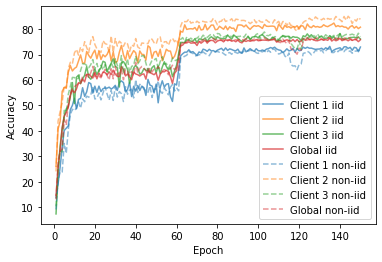

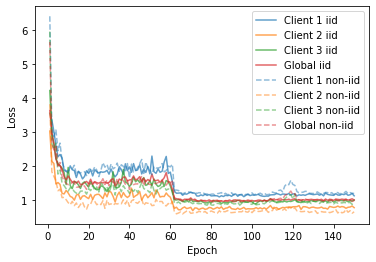

In [37]:
iid = torch.load('results/cifar100/iid/epoch_150/server_trained_on_client_3.pth')['stats']
non_iid = torch.load('results/cifar100/non-iid/epoch_150/server_trained_on_client_2.pth')['stats']

# Plot iid
val = iid['val']
val_acc = pd.DataFrame(val['accuracy'])
val_acc['Epoch'] = val_acc.index.values
ax = val_acc.plot(x='Epoch', y=[0, 1, 2]+['global'], kind='line', alpha=0.7)

# Plot iid
val = non_iid['val']
val_acc = pd.DataFrame(val['accuracy'])
val_acc['Epoch'] = val_acc.index.values
val_acc.plot(x='Epoch', y=[0, 1, 2]+['global'], kind='line', linestyle='--', 
             color=['C0', 'C1', 'C2', 'C3'], ax=ax, alpha=0.5)
ax.set_ylabel("Accuracy")
ax.legend(['Client 1 iid', 'Client 2 iid', 'Client 3 iid', 'Global iid', 
          'Client 1 non-iid', 'Client 2 non-iid', 'Client 3 non-iid', 'Global non-iid'])
ax.figure.savefig(os.path.join(save_path, 'val_acc.png'))

# Plot iid
val = iid['val']
val_acc = pd.DataFrame(val['loss'])
print(val_acc)
val_acc['Epoch'] = val_acc.index.values
ax = val_acc.plot(x='Epoch', y=[0, 1, 2]+['global'], kind='line', alpha=0.7)

# Plot iid
val = non_iid['val']
val_acc = pd.DataFrame(val['loss'])
val_acc['Epoch'] = val_acc.index.values
val_acc.plot(x='Epoch', y=[0, 1, 2]+['global'], kind='line', linestyle='--', 
             color=['C0', 'C1', 'C2', 'C3'], ax=ax, alpha=0.5)
ax.set_ylabel("Loss")
ax.legend(['Client 1 iid', 'Client 2 iid', 'Client 3 iid', 'Global iid', 
          'Client 1 non-iid', 'Client 2 non-iid', 'Client 3 non-iid', 'Global non-iid'])
ax.figure.savefig(os.path.join(save_path, 'val_loss.png'))